# Recreating the Berliner Morgenpost's "spikes" electoral maps in Python for the UK General Election 2017-2019

Inspired by the [maps](https://interaktiv.morgenpost.de/analyse-bundestagswahl-2017/) created by the Berliner Morgenpost to show electoral swing in the German Federal Elections.

- [Constituency boundaries](https://geoportal.statistics.gov.uk/datasets/westminster-parliamentary-constituencies-december-2017-generalised-clipped-boundaries-in-the-uk) from the Ordnance Survey Geoportal
- [Electoral data 2019](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-8749) from UK Parliament Research Briefings
- [Electoral data 2017](https://researchbriefings.parliament.uk/ResearchBriefing/Summary/CBP-7979) from UK Parliament Research Briefings
- [Party colours](https://en.wikipedia.org/wiki/Wikipedia:Index_of_United_Kingdom_political_parties_meta_attributes) from Wikipedia
- [Colour shades](https://www.color-hex.com/color/2aa82c) calculated using Color-Hex.Com


In [1]:
# Libraries
import pandas as pd 
import geojsonio
import numpy as np
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
import shapely
from shapely.geometry import shape, Point
from pyproj import Proj, transform
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Import electoral results data file
Get acquainted with the field names. In this files, I have all data about turnout, valid votes, etc, for each party in 2017 and 2019

In [2]:
results = pd.read_csv('general.csv')
results.head()

,ons_id,constituency_name,electorate2019,valid_votes2019,invalid_votes2019,majority2019,con2019,lab2019,ld2019,brexit2019,...,green2017,snp2017,pc2017,dup2017,sf2017,sdlp2017,uup2017,alliance2017,other2017,other_winner2017
0,E14000530,Aldershot,72617,47932,251,16698,27980,11282,6920,0,...,1090,0,0,0,0,0,0,0,0,0
1,E14000531,Aldridge-Brownhills,60138,39342,152,19836,27850,8014,2371,0,...,0,0,0,0,0,0,0,0,565,0
2,E14000532,Altrincham and Sale West,73107,54763,173,6139,26311,20172,6036,0,...,1000,0,0,0,0,0,0,0,299,0
3,E14000533,Amber Valley,69976,45567,151,16886,29096,12210,2873,0,...,650,0,0,0,0,0,0,0,551,0
4,E14000534,Arundel and South Downs,81726,61408,287,22521,35566,9722,13045,0,...,2542,0,0,0,0,0,0,0,0,0


# Calculate "deltas" percentages to display the variation
Simple formula party_votes/valid_votes is each election's share of the vote for a specific constituency. According to what party map you want to generate, you will add more or fewer columns with the delta between the two elections. 
You might need to play with the data in case of party renames, splits, mergers, etc. For example, here I consider Brexit 2019 as the evolution of UKIP 2017, although this isn't quite correct.

In [3]:
results['LABdeltaPC'] = (results['lab2019']/results['valid_votes2019'] - results['lab2017']/results['valid_votes2017']) * 100
results['CONdeltaPC'] = (results['con2019']/results['valid_votes2019'] - results['con2017']/results['valid_votes2017']) * 100
results['LDdeltaPC'] = (results['ld2019']/results['valid_votes2019'] - results['ld2017']/results['valid_votes2017']) * 100
results['SNPdeltaPC'] = (results['snp2019']/results['valid_votes2019'] - results['snp2017']/results['valid_votes2017']) * 100
results['GRNdeltaPC'] = (results['green2019']/results['valid_votes2019'] - results['green2017']/results['valid_votes2017']) * 100
results['DUPdeltaPC'] = (results['dup2019']/results['valid_votes2019'] - results['dup2017']/results['valid_votes2017']) * 100
results['SDLPdeltaPC'] = (results['sdlp2019']/results['valid_votes2019'] - results['sdlp2017']/results['valid_votes2017']) * 100
results['SFdeltaPC'] = (results['sf2019']/results['valid_votes2019'] - results['sf2017']/results['valid_votes2017']) * 100
results['BREXITdeltaPC'] = (results['brexit2019']/results['valid_votes2019'] - results['ukip2017']/results['valid_votes2017']) * 100                                                           
results.head()

,ons_id,constituency_name,electorate2019,valid_votes2019,invalid_votes2019,majority2019,con2019,lab2019,ld2019,brexit2019,...,other_winner2017,LABdeltaPC,CONdeltaPC,LDdeltaPC,SNPdeltaPC,GRNdeltaPC,DUPdeltaPC,SDLPdeltaPC,SFdeltaPC,BREXITdeltaPC
0,E14000530,Aldershot,72617,47932,251,16698,27980,11282,6920,0,...,0,-8.080466,3.318184,7.007089,0.0,1.424244,0.0,0.0,0.0,-3.669050
1,E14000531,Aldridge-Brownhills,60138,39342,152,19836,27850,8014,2371,0,...,0,-9.479545,5.381260,2.688748,0.0,1.959738,0.0,0.0,0.0,0.000000
2,E14000532,Altrincham and Sale West,73107,54763,173,6139,26311,20172,6036,0,...,0,-2.011283,-2.973919,3.348239,0.0,0.965297,0.0,0.0,0.0,0.000000
3,E14000533,Amber Valley,69976,45567,151,16886,29096,12210,2873,0,...,0,-11.633927,7.305673,3.903831,0.0,1.627191,0.0,0.0,0.0,0.000000
4,E14000534,Arundel and South Downs,81726,61408,287,22521,35566,9722,13045,0,...,0,-6.887916,-4.438081,13.305362,0.0,-0.116596,0.0,0.0,0.0,-2.768189


# Import the map and plot it

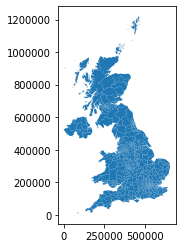

In [34]:
# Assumption: you have a map in geojson format
#
# If you have an ESRI shapefile, you can convert it into GeoJSON e.g.
# ogr2ogr -f GeoJSON countries.json ne_10m_admin_0_countries_lakes.shp
# (http://www.tnoda.com/blog/2013-12-07)
#
# Other useful tips:
# https://gis.stackexchange.com/questions/78838/converting-projected-coordinates-to-lat-lon-using-python
# https://stackoverflow.com/questions/39620105/converting-between-projections-using-pyproj-in-pandas-dataframe
# https://github.com/geohackweek/tutorial_contents/blob/master/vector/notebooks/geopandas_intro.ipynb

mapdf = gpd.read_file('constituenciesUK.geojson')

mapdf.plot() # If this has worked, it should draw a map of constituencies!

# See what a geographical data frame looks like
It's important to explore the data. You will need to join the two datasets based on the unique value. In this case, this will be the ONS code for the constituency, however if you can be sure you have the same constituency names everywhere, you could also join based on name instead (errors might be hard to find!)

In [35]:
mapdf.head()
# You should see a number of parameters; what matters is the presence of a unique value (GSS_CODE, but also NAME in this case)
# and a column called "geometry", that contains the councils polygons
# We'll need to match the two data frames

,objectid,pcon17cd,pcon17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E14000530,Aldershot,484884,155126,-0.7841,51.289001,5.300200e+07,40826.569141,"POLYGON ((485406.902 159918.603, 485465.904 15..."
1,2,E14000531,Aldridge-Brownhills,404723,302568,-1.9316,52.620899,4.403349e+07,38222.291898,"POLYGON ((400715.498 304323.098, 400862.202 30..."
2,3,E14000532,Altrincham and Sale West,374132,389051,-2.3904,53.397701,5.092603e+07,46097.782457,"POLYGON ((369941.302 390805.702, 369994.598 39..."
3,4,E14000533,Amber Valley,440478,349675,-1.3977,53.042801,1.246377e+08,62106.010829,"POLYGON ((444868.402 353958.100, 444796.497 35..."
4,5,E14000534,Arundel and South Downs,510689,115542,-0.4263,50.928699,6.452209e+08,328652.510840,"MULTIPOLYGON (((520051.591 112423.909, 520087...."


# Calculating where to positions the spikes
Each spike is basically a triangle. We want to position each triangle around the centroid of each constituency polygon. Let's do an intermediate step, then: we add longitude and latitude of each centroid.

In [36]:
# Add lon/lat of centroid to our polygons 
data = dict()
data['name'] = []
data['lat'] = []
data['lon'] = []
i = 0

# We iterate over each geometry
for geom in mapdf['geometry']:
    # calculate the centroid coordinates
    centroid = shape(geom).centroid.coords
    # centroid = shape(geom).centroid.wkt
    lon = centroid[0][0] 
    lat = centroid[0][1]
    # data['name'].append(i)
    data['lon'].append(lon)
    data['lat'].append(lat)
    
    
mapdf['centroidlon'] = data['lon']
mapdf['centroidlat'] = data['lat']

mapdf.head(5)

,objectid,pcon17cd,pcon17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,centroidlon,centroidlat
0,1,E14000530,Aldershot,484884,155126,-0.7841,51.289001,5.300200e+07,40826.569141,"POLYGON ((485406.902 159918.603, 485465.904 15...",485388.803432,154739.476477
1,2,E14000531,Aldridge-Brownhills,404723,302568,-1.9316,52.620899,4.403349e+07,38222.291898,"POLYGON ((400715.498 304323.098, 400862.202 30...",404962.421483,301838.253792
2,3,E14000532,Altrincham and Sale West,374132,389051,-2.3904,53.397701,5.092603e+07,46097.782457,"POLYGON ((369941.302 390805.702, 369994.598 39...",375776.718513,388581.927701
3,4,E14000533,Amber Valley,440478,349675,-1.3977,53.042801,1.246377e+08,62106.010829,"POLYGON ((444868.402 353958.100, 444796.497 35...",440328.614652,349351.163774
4,5,E14000534,Arundel and South Downs,510689,115542,-0.4263,50.928699,6.452209e+08,328652.510840,"MULTIPOLYGON (((520051.591 112423.909, 520087....",508706.197300,115405.759961


# Join the two data sets
The two data frames use the same unique IDs for councils, so we can merge them into one by using the relevant columns

In [37]:
# Merge the wards dataset with the results dataset for ease
df = pd.merge(mapdf, results, how = 'left', left_on = 'pcon17cd', right_on = 'ons_id')
df.head()

,objectid,pcon17cd,pcon17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,...,other_winner2017,LABdeltaPC,CONdeltaPC,LDdeltaPC,SNPdeltaPC,GRNdeltaPC,DUPdeltaPC,SDLPdeltaPC,SFdeltaPC,BREXITdeltaPC
0,1,E14000530,Aldershot,484884,155126,-0.7841,51.289001,5.300200e+07,40826.569141,"POLYGON ((485406.902 159918.603, 485465.904 15...",...,0,-8.080466,3.318184,7.007089,0.0,1.424244,0.0,0.0,0.0,-3.669050
1,2,E14000531,Aldridge-Brownhills,404723,302568,-1.9316,52.620899,4.403349e+07,38222.291898,"POLYGON ((400715.498 304323.098, 400862.202 30...",...,0,-9.479545,5.381260,2.688748,0.0,1.959738,0.0,0.0,0.0,0.000000
2,3,E14000532,Altrincham and Sale West,374132,389051,-2.3904,53.397701,5.092603e+07,46097.782457,"POLYGON ((369941.302 390805.702, 369994.598 39...",...,0,-2.011283,-2.973919,3.348239,0.0,0.965297,0.0,0.0,0.0,0.000000
3,4,E14000533,Amber Valley,440478,349675,-1.3977,53.042801,1.246377e+08,62106.010829,"POLYGON ((444868.402 353958.100, 444796.497 35...",...,0,-11.633927,7.305673,3.903831,0.0,1.627191,0.0,0.0,0.0,0.000000
4,5,E14000534,Arundel and South Downs,510689,115542,-0.4263,50.928699,6.452209e+08,328652.510840,"MULTIPOLYGON (((520051.591 112423.909, 520087....",...,0,-6.887916,-4.438081,13.305362,0.0,-0.116596,0.0,0.0,0.0,-2.768189


# Draw the spikes
We'll do this one party at a time. There are four simple steps:
- we set the size of the triangles (you will need to play around with these and see what size works best for the geography you've selected)
- we calculate the base vertex to be around the centroid
- we calculate the height
- we calculate each edge, to be drawn as a 'patch'


In [74]:
# Which variable are we drawing, and which colour we want it to be

HALF_BASE = 3000
HEIGHT_MULTIPLIER = 5000 # how tall you want your spikes

# the list is a set of tuples: ['Party short symbol', 'primary colour for positive swing', 'secondary colour for negative swing', 'long name']
partylist = [['LAB','#DC241f','#ed918f', 'Labour Party'], ['CON','#0087DC', '#99cff1', 'Conservatives'], ['LD','#FDBB30', '#fee3ac', 'Liberal Democrats'], ['BREXIT','#12B6CF', '#a0e1eb', 'Brexit Party'], ['SNP','#FFF95D', '#fffcbe', 'Scottish National Party'], ['DUP','#D46A4C', '#edc3b7', 'Democratic Unionist Party'], ['SF','#326760', '#adc2bf', 'Sinn Fein'], ['SDLP', '#2AA82C', '#a9dcaa', 'Social Democratic and Labour Party'], ['GRN','#6AB023', '#c3dfa7', 'Green Party']]

for party in partylist:
    columnparty = party[0]+'deltaPC'
    columnL = 'triangleL'+party[0]
    columnR = 'triangleR'+party[0]
    columnH = 'triangleH'+party[0]

    df[columnL] = df['centroidlon'] - HALF_BASE
    df[columnR] = df['centroidlon'] + HALF_BASE
    df[columnH] = df['centroidlat'] + HEIGHT_MULTIPLIER * df[columnparty]


df.head(3)

,objectid,pcon17cd,pcon17nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,...,triangleHDUP,triangleLSF,triangleRSF,triangleHSF,triangleLGRN,triangleRGRN,triangleHGRN,triangleLSDLP,triangleRSDLP,triangleHSDLP
0,1,E14000530,Aldershot,484884,155126,-0.7841,51.289001,5.300200e+07,40826.569141,"POLYGON ((485406.902 159918.603, 485465.904 15...",...,154739.476477,482388.803432,488388.803432,154739.476477,482388.803432,488388.803432,161860.694423,482388.803432,488388.803432,154739.476477
1,2,E14000531,Aldridge-Brownhills,404723,302568,-1.9316,52.620899,4.403349e+07,38222.291898,"POLYGON ((400715.498 304323.098, 400862.202 30...",...,301838.253792,401962.421483,407962.421483,301838.253792,401962.421483,407962.421483,311636.942216,401962.421483,407962.421483,301838.253792
2,3,E14000532,Altrincham and Sale West,374132,389051,-2.3904,53.397701,5.092603e+07,46097.782457,"POLYGON ((369941.302 390805.702, 369994.598 39...",...,388581.927701,372776.718513,378776.718513,388581.927701,372776.718513,378776.718513,393408.411798,372776.718513,378776.718513,388581.927701


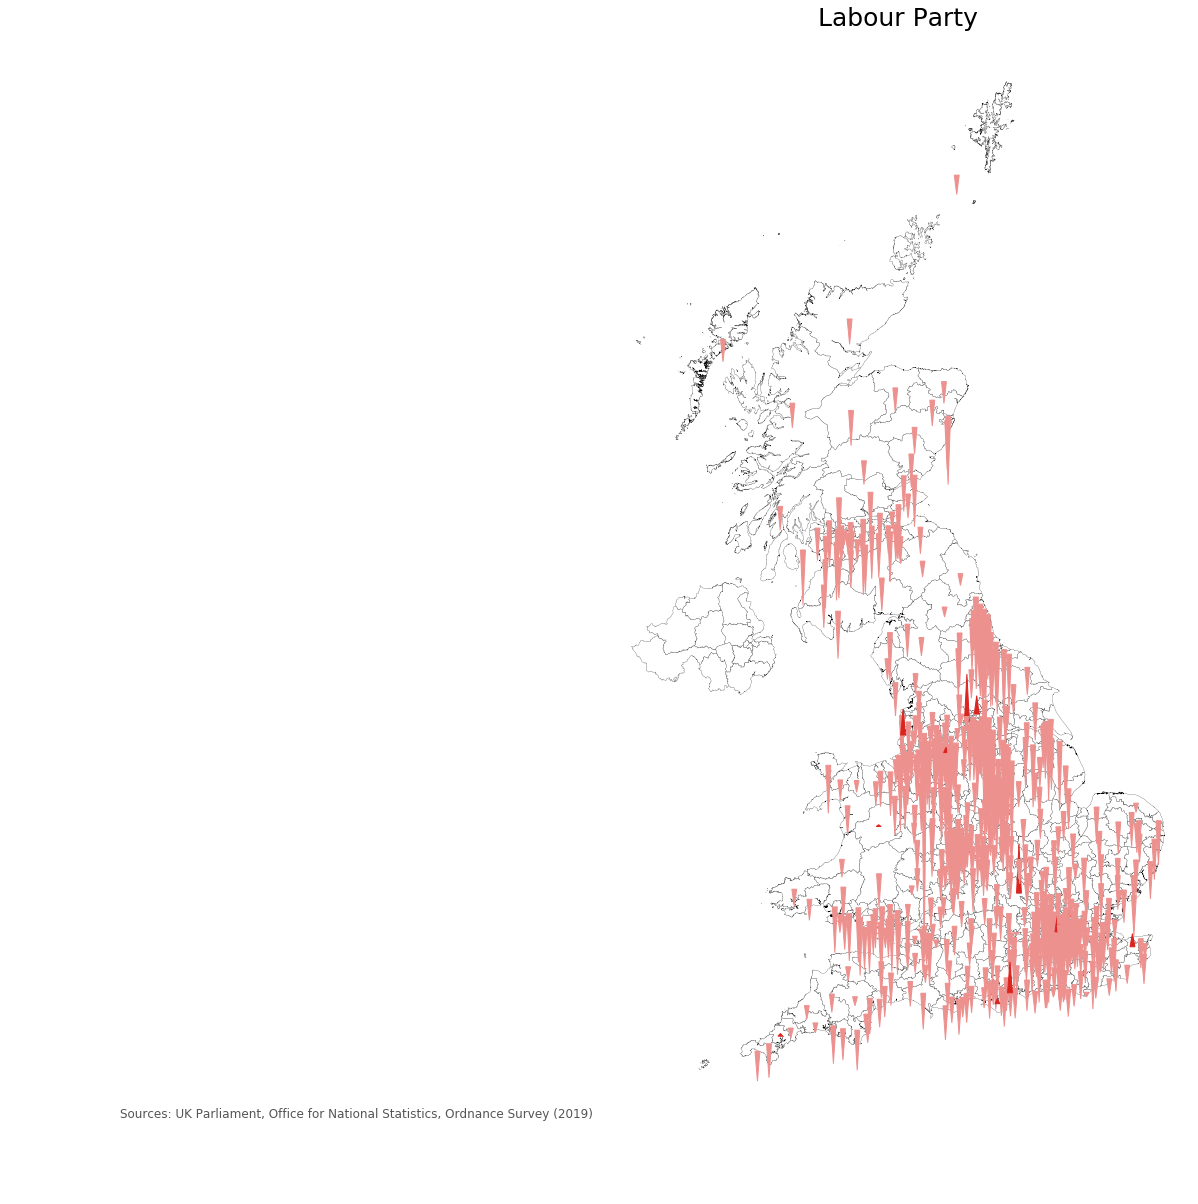

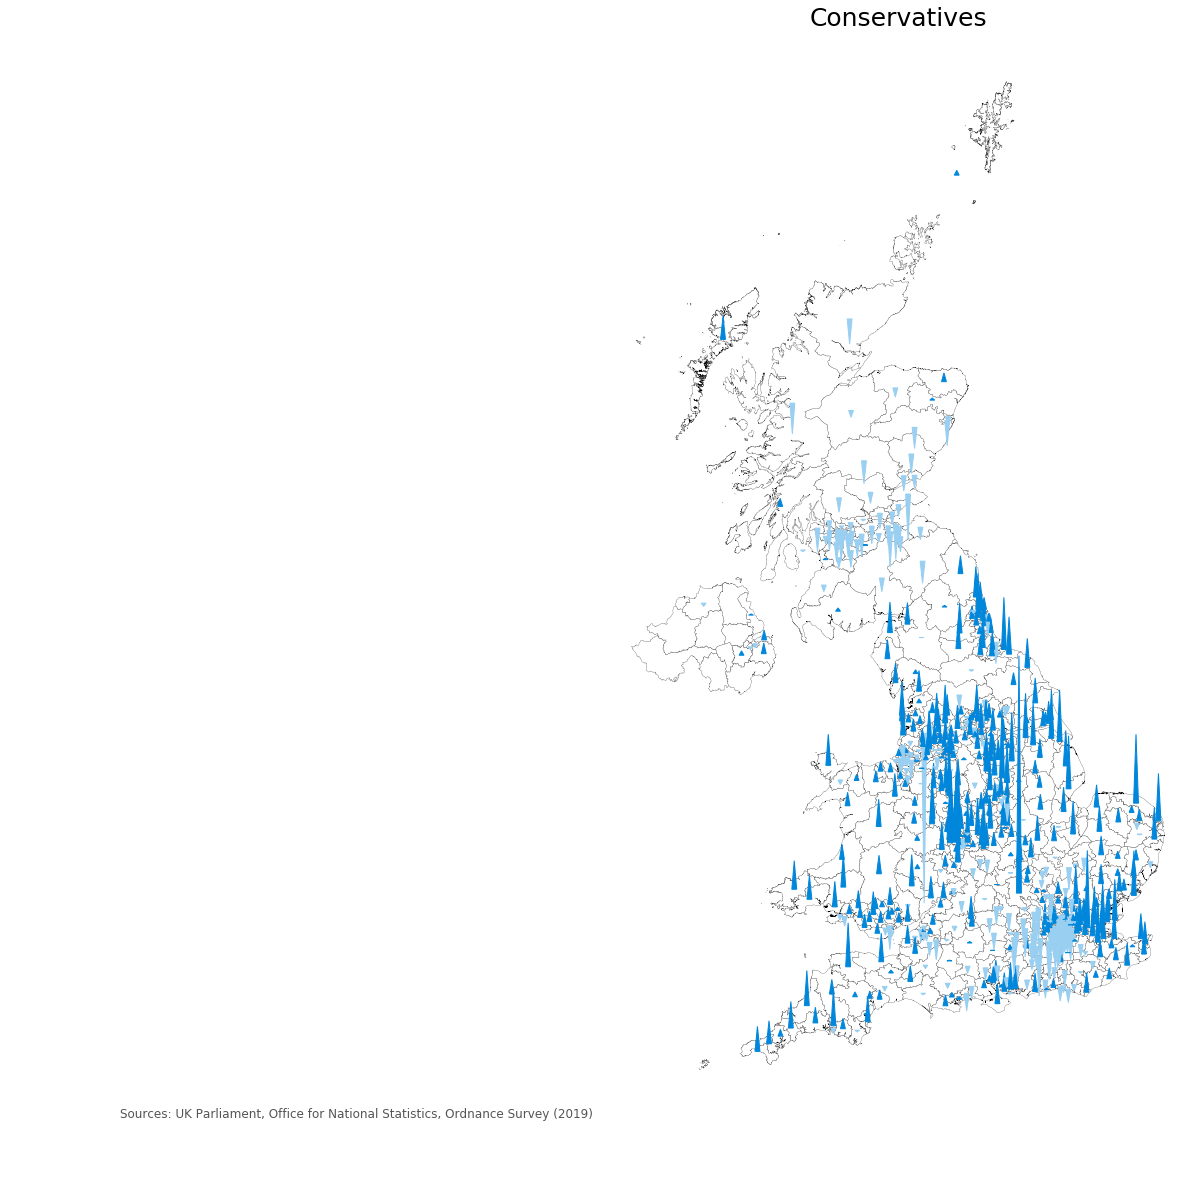

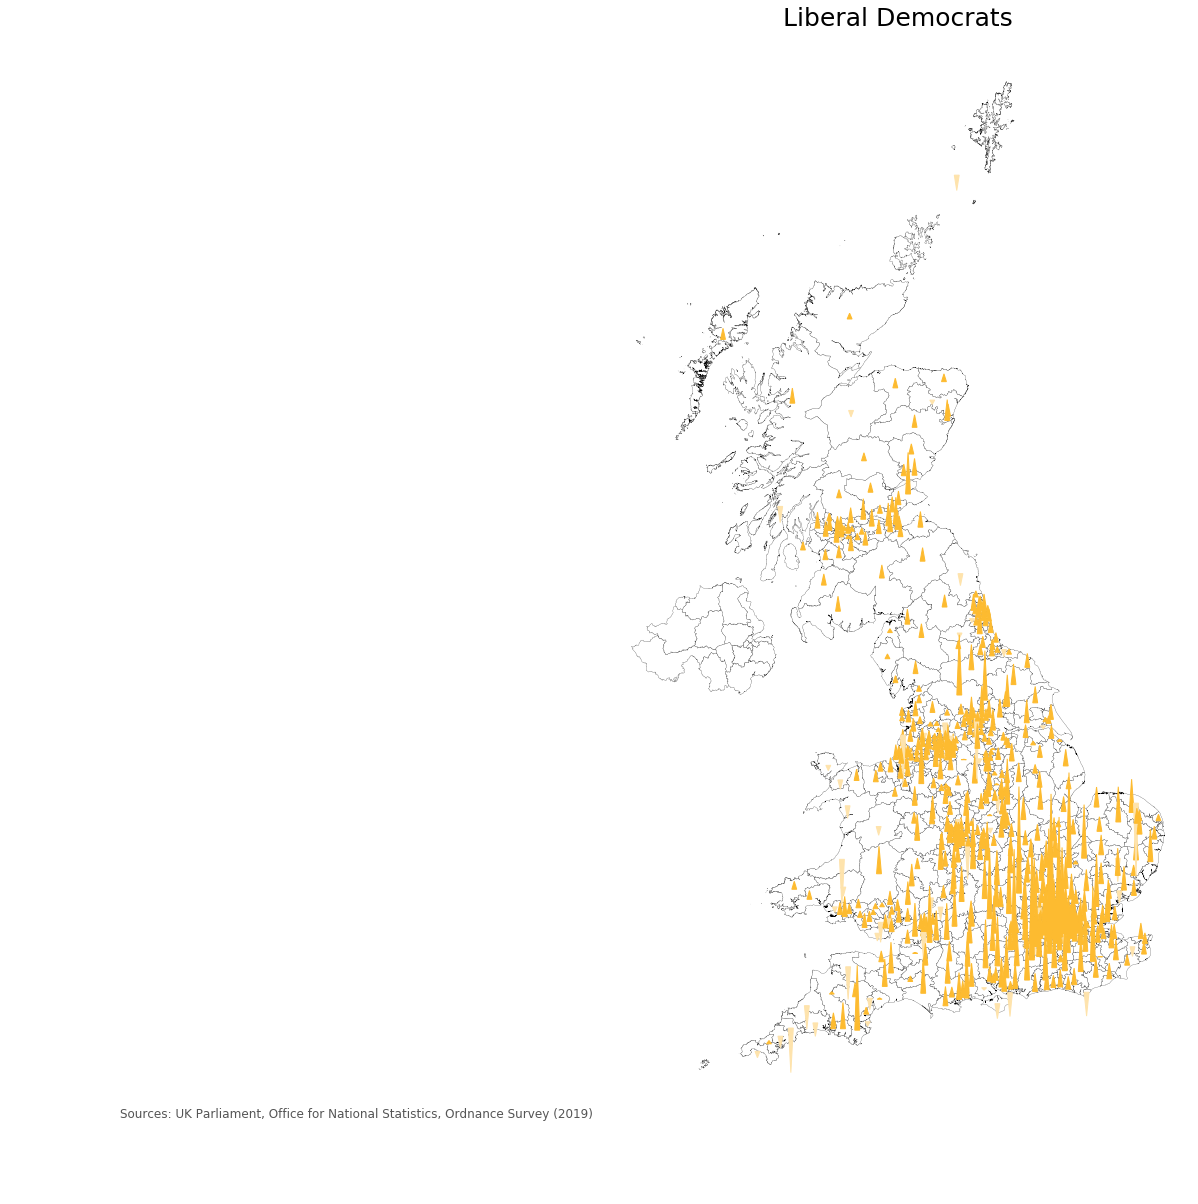

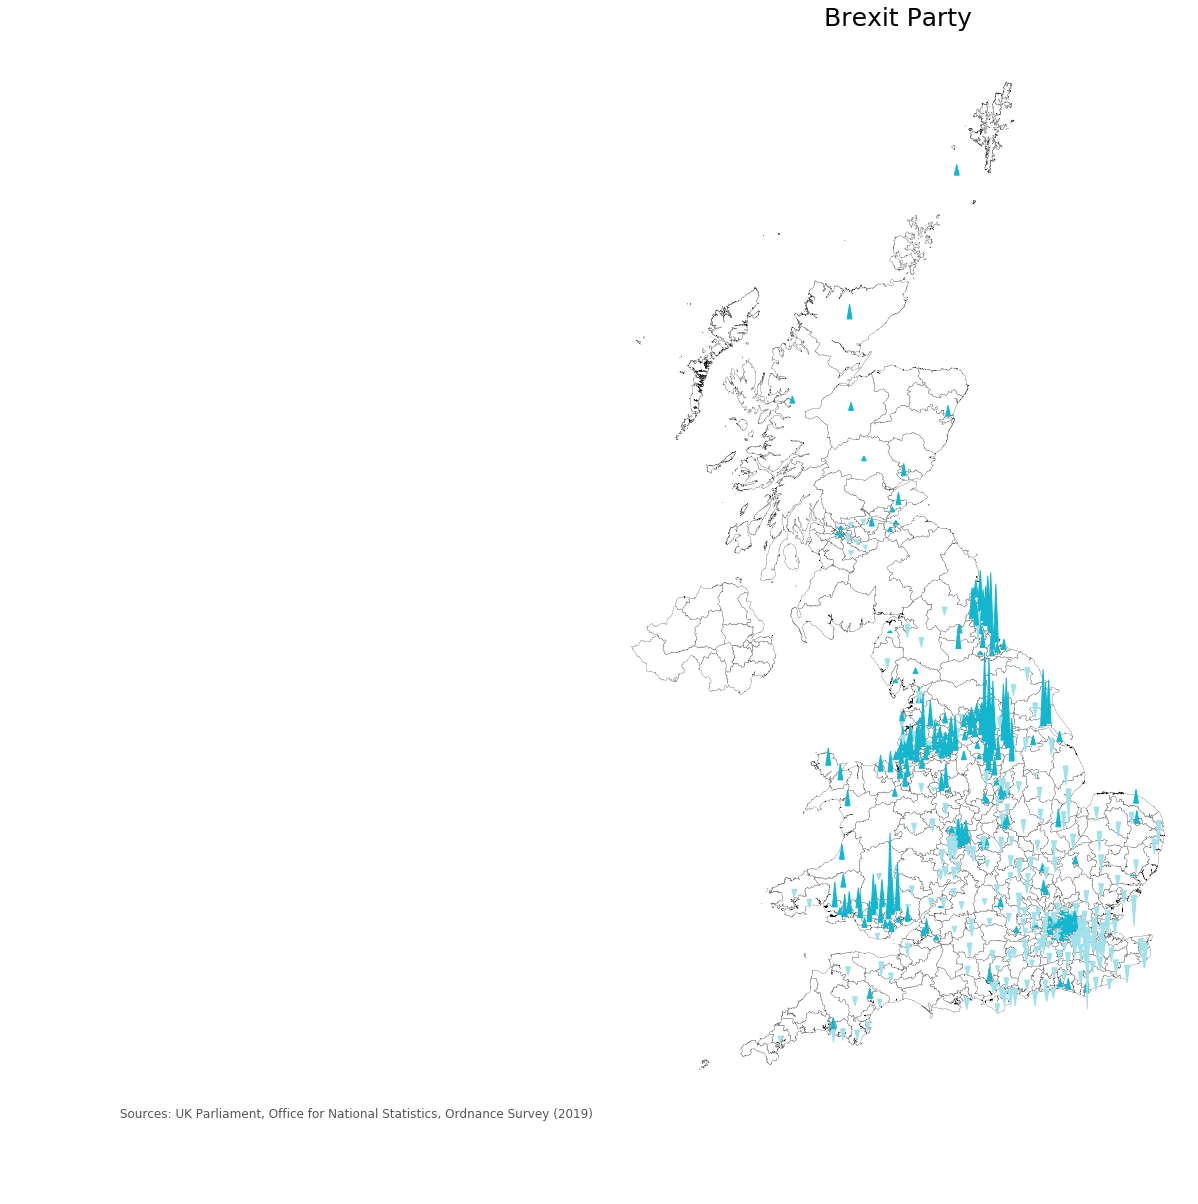

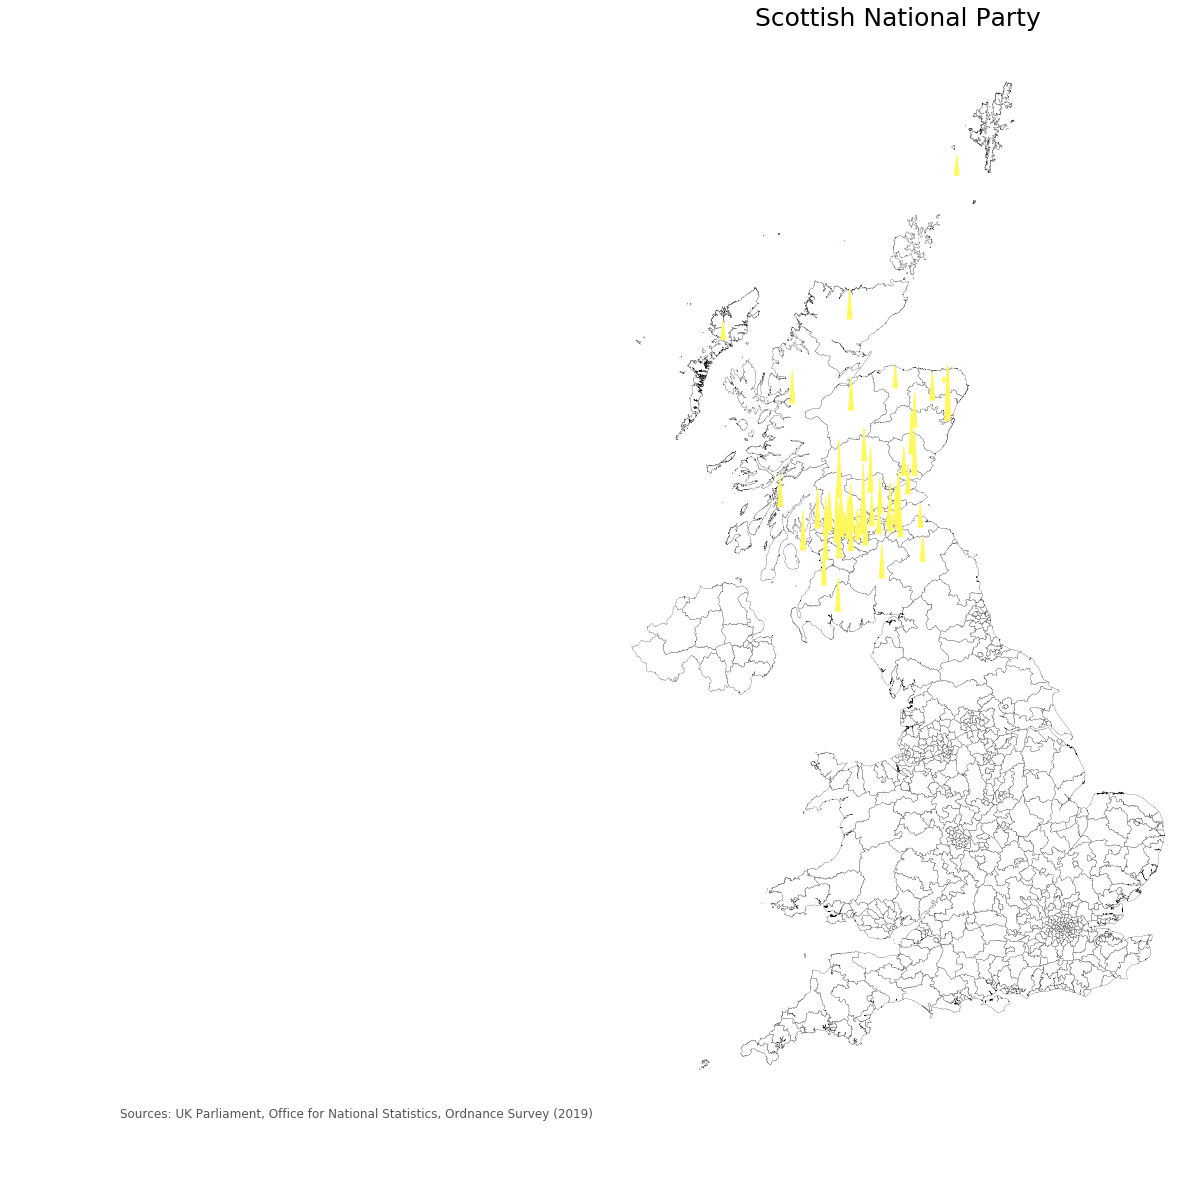

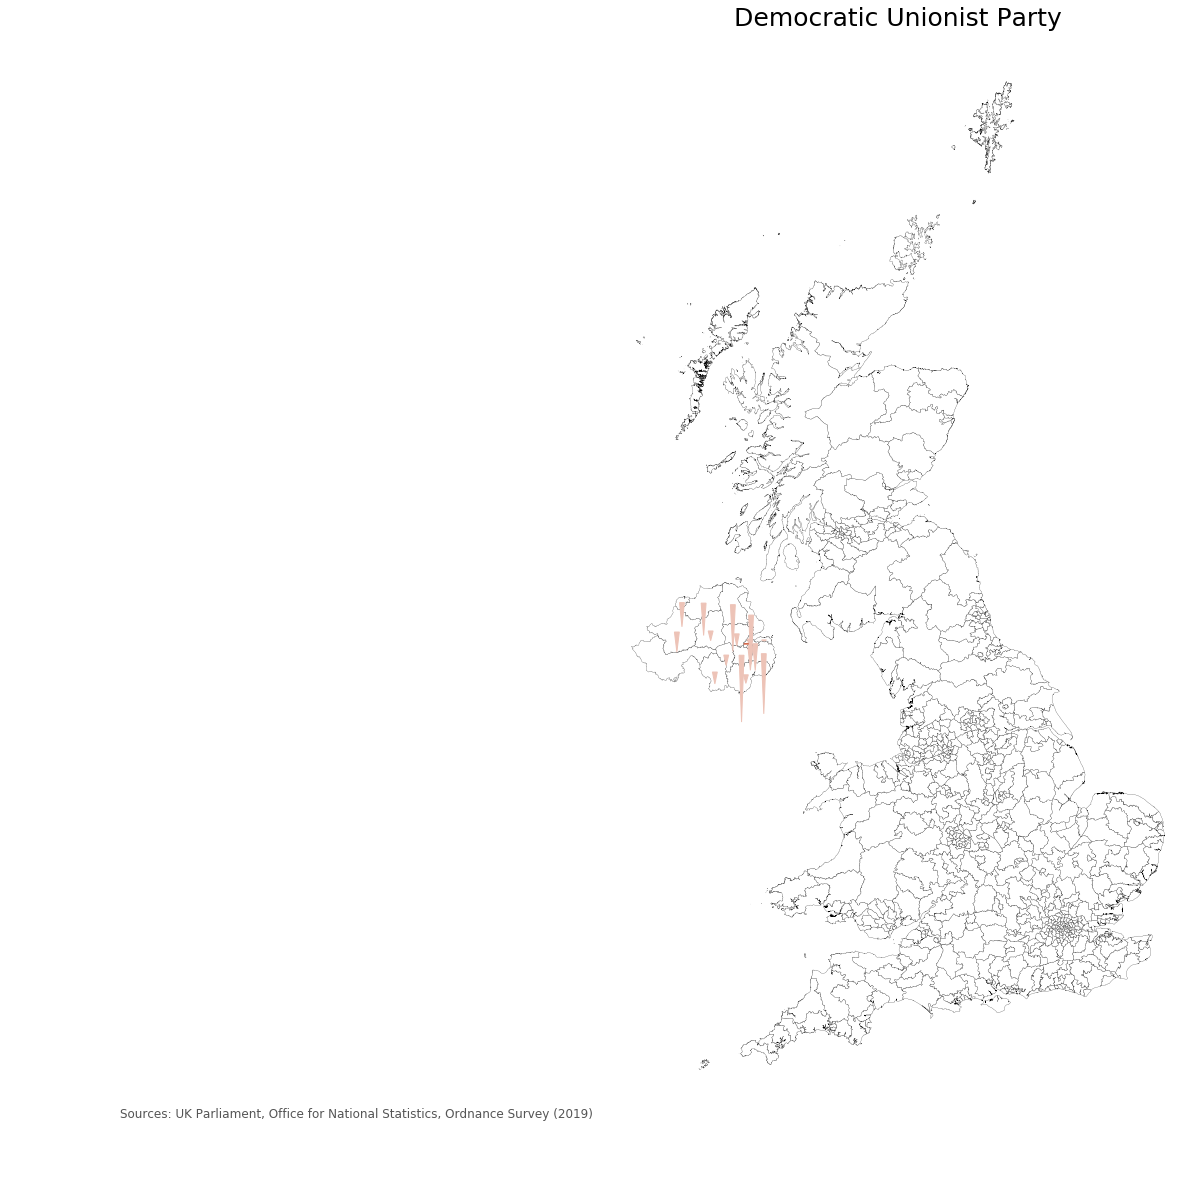

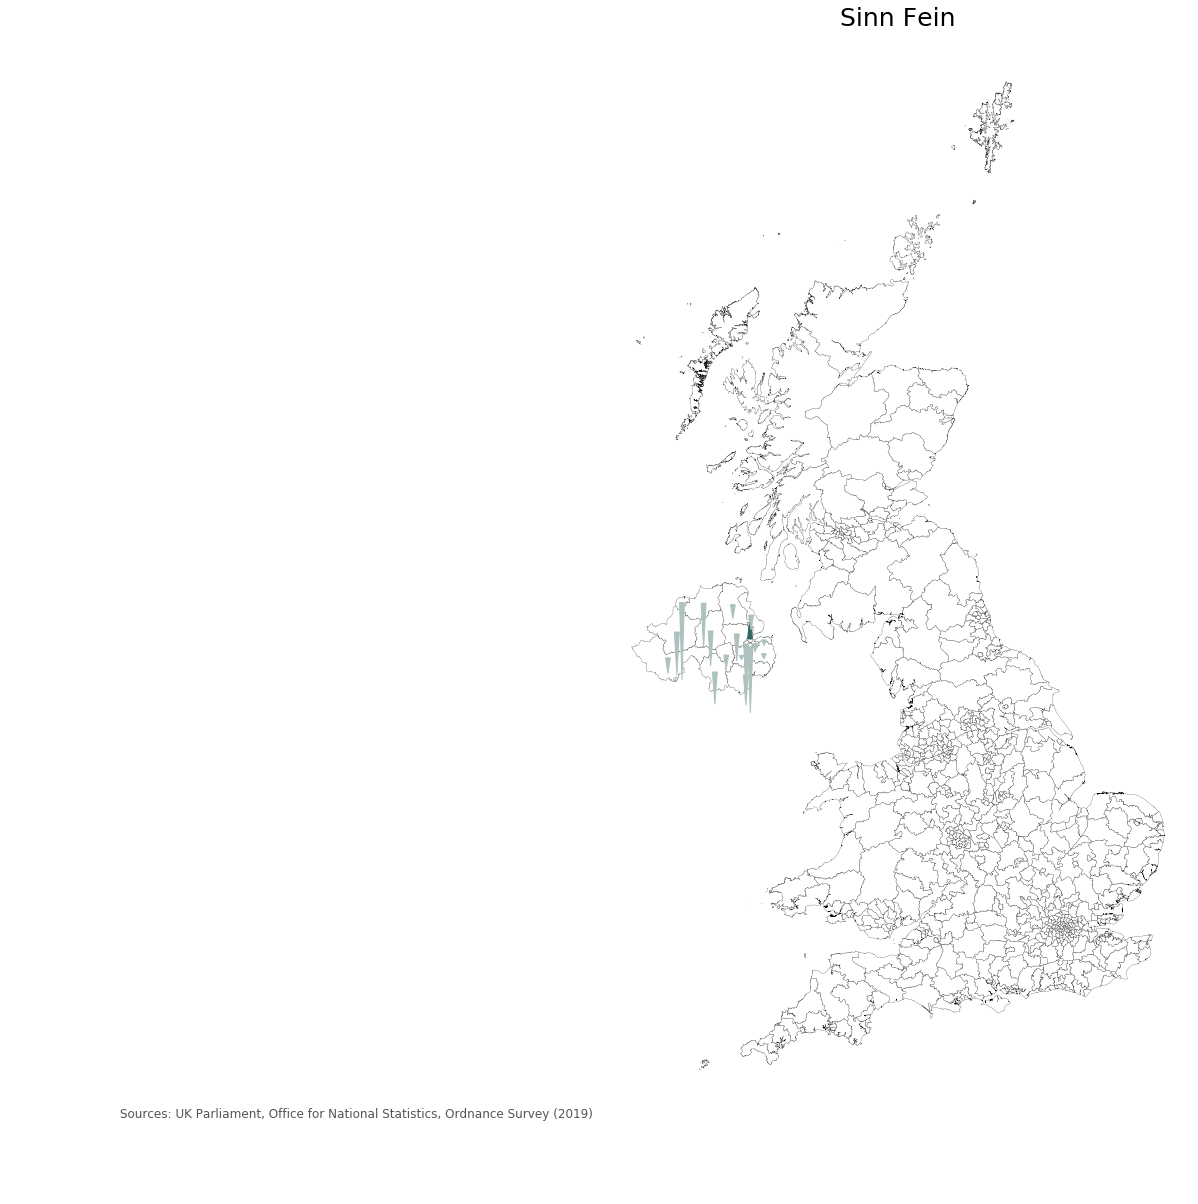

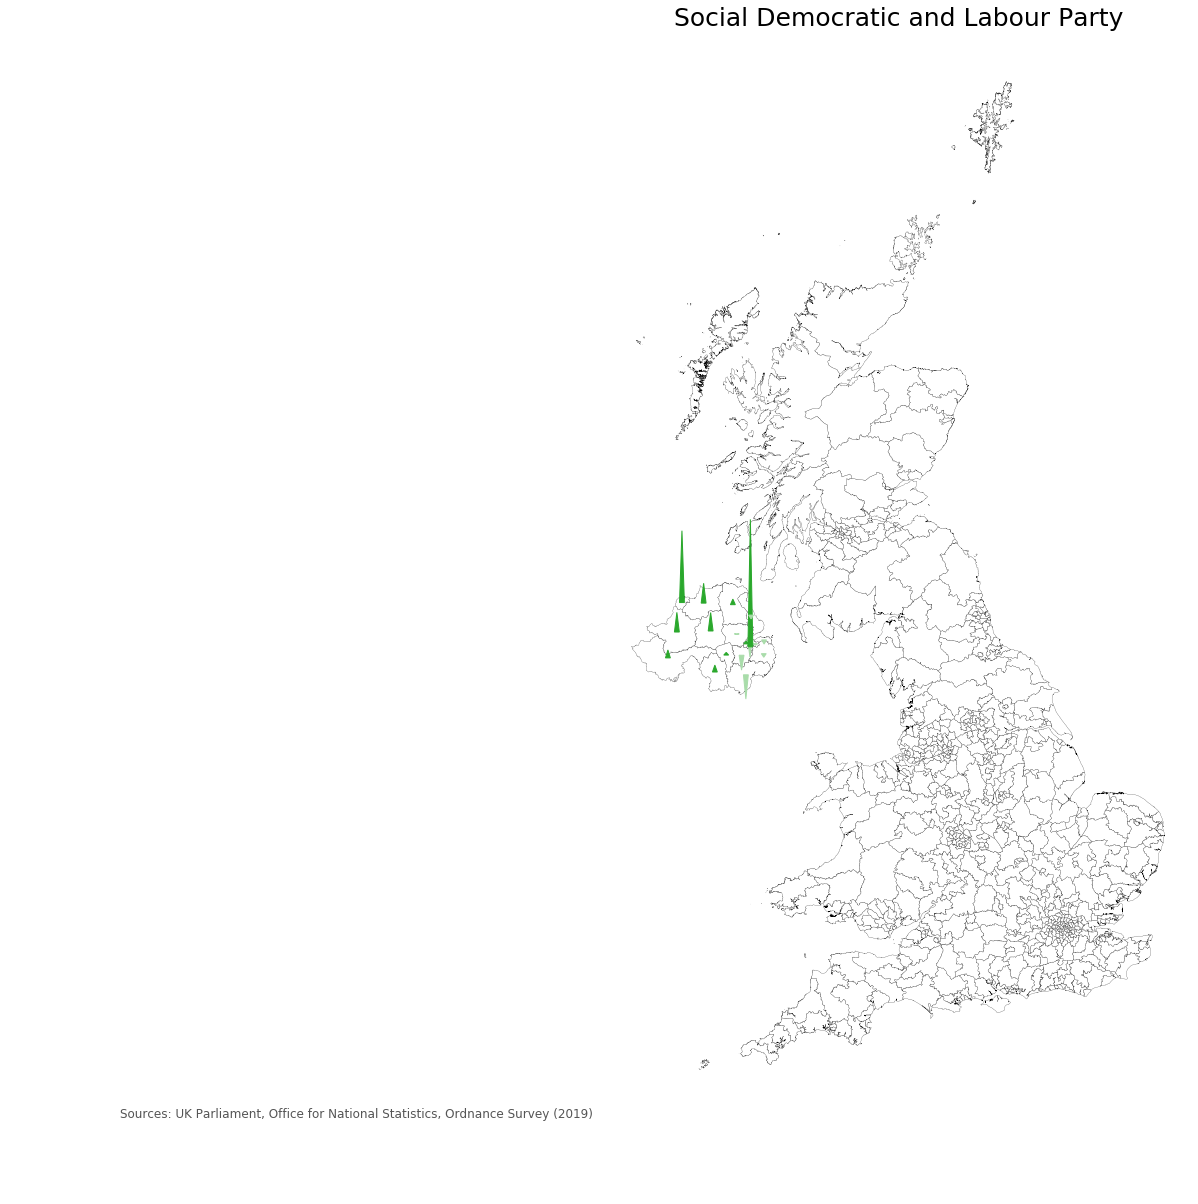

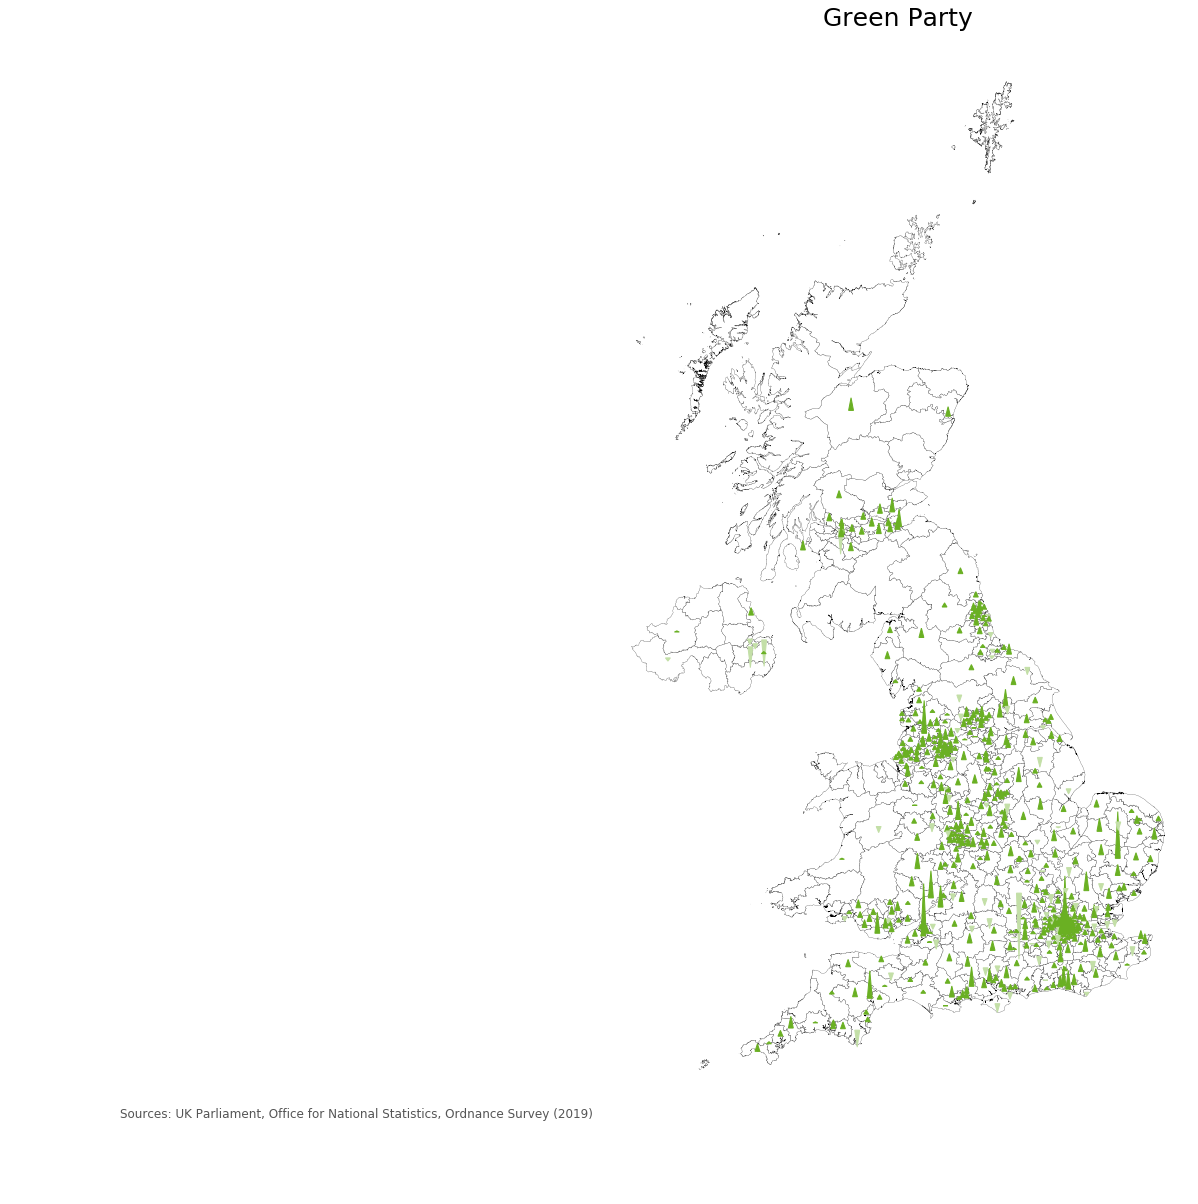

In [75]:
for partyitem in partylist:
    PARTY = partyitem[0]
    PARTY_COLOUR = partyitem[1]
    NEG_COLOUR = partyitem[2]
    TITLE = partyitem[3]
    
    columnL = 'triangleL'+PARTY
    columnR = 'triangleR'+PARTY
    columnH = 'triangleH'+PARTY

    # Using the vertices, calculate the edges
    pointsX = []
    pointsY = [] 
    patches = [] # patches == edges, except they are the technical term for drawing on a map
    
    
    # calculate triangles and turn them into patches
    for index, row in df.iterrows():

        L = row[columnL]
        R = row[columnR]
        H = row[columnH]

        lat = row['centroidlat']
        lon = row['centroidlon']

        pointx1 = L
        pointx2 = R
        pointx3 = lon
        pointy1 = lat
        pointy2 = lat
        pointy3 = H

        pointsX.append(L)
        pointsX.append(R)
        pointsX.append(lon)

        pointsY.append(lat)
        pointsY.append(lat)
        pointsY.append(H)

        # change of colour for negative swing
        if (H <= lat):
            USE_COLOUR = NEG_COLOUR
        else:
            USE_COLOUR = PARTY_COLOUR
        
        patch = plt.Polygon([[L,lat], [R,lat], [lon,H]], color=USE_COLOUR)

        # don't display where the swing is exactly 0 (e.g. the party did not stand, or the got exactly the same vote share)
        if (H != lat):
            patches.append(patch)        


    # Let's draw the underlying map
    ax = mapdf.plot(figsize=(30,20), color='white', edgecolor='black', linewidth=0.2)
    ax.set_facecolor('white')    
    ax.axis('off')
    ax.set_title(TITLE, fontdict={'fontsize': 25, 'fontweight': 3})
    ax.annotate('Sources: UK Parliament, Office for National Statistics, Ordnance Survey (2019)',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    

    # Finally, draw the patches 
    for patch in patches:
        ax.add_patch(patch)

In [71]:
# Contains National Statistics data © Crown copyright and database right [2017]
# Contains Ordnance Survey data © Crown copyright and database right [2017]
# Contains data from UK Parliament [2019]